# Library

In [1]:
import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import unidecode
import string

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import sparse

from sklearn.pipeline import Pipeline, FeatureUnion, make_union
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss

# Data

## train

In [2]:
df_train = pd.read_csv("../data/input/train.csv")
targets = [
    'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'
]

## Test

In [3]:
df_test = pd.read_csv("../data/input/test.csv")
df_test.loc[df_test.comment_text.isnull(), "comment_text"] = ""

# Text cleaning

## clean text

In [4]:
def clean_text(x, lemmatize=False):
    if type(x) == np.ndarray:
        x = pd.Series(x)
    # carriage return
    x = x.str.replace("\n", "")
    # To lower
    x = x.str.lower()
    # Remove digits
    x = x.str.replace('\d+', '')
    # Remove url
    x = x.str.replace('http\S+', "")
    # Remove extra white spaces
    x = x.str.replace('[^\w\s]', ' ')
    x = x.str.replace(r"what's", "what is ")
    x = x.str.replace(r"\'s", " ")
    x = x.str.replace(r"\'ve", " have ")
    x = x.str.replace(r"can't", "cannot ")
    x = x.str.replace(r"n't", " not ")
    x = x.str.replace(r"i'm", "i am ")
    x = x.str.replace(r"\'re", " are ")
    x = x.str.replace(r"\'d", " would ")
    x = x.str.replace(r"\'ll", " will ")
    x = x.str.replace(r"\'scuse", " excuse ")
    # Remove white space begin end string
    x = x.str.strip()
    if lemmatize:
        lemmatiser = WordNetLemmatizer()
        x = x.map(lambda sentence : " ".join([lemmatiser.lemmatize(word.strip()) for word in sentence.split(' ') if word not in ["", " ", "  "]]))
    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    x = x.map(lambda sentence: sentence.translate(translator))
    # Remove stopwords
    stop_words = stopwords.words('english') + ["wikipedia", "wiki"]
    x = x.map(lambda sentence : " ".join([word for word in sentence.split(" ") if (word not in stop_words) and (len(word) > 1)]))
    return x.values

## Custom transformer for pipeline

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin


class CleanText(BaseEstimator, TransformerMixin):
    def __init__(self, lemmatize=False, active=False):
        self.lemmatize = lemmatize
        self.active = active

    def fit(self, X, y):
        return self

    def transform(self, x):
        if self.active:
            return clean_text(pd.Series(x), lemmatize=self.lemmatize)
        else:
            return x

# Pipeline

In [6]:
run_pipeline = True

if run_pipeline:
    from tempfile import mkdtemp
    from shutil import rmtree
    cachedir = mkdtemp()

    result_logistic = {}

    for target in targets:
        print(target)

        logistic_clf = Pipeline(
            [
                ("cleanText", CleanText(lemmatize=False)),
                ('tfidf', TfidfVectorizer(
                    max_df=0.95,
                    min_df=5,
                    max_features=30000,
                    strip_accents="unicode",
                    stop_words="english",
                    lowercase=False)),
                ('clf', LogisticRegression()),
            ],
            memory=cachedir)

        parameters = {
            'tfidf__ngram_range': [(1, 1), (1, 2)],
            #'cleanText__active': (True, False), # uncomment to test if clean text has an impact
            'clf__C': (0.1, 0.5, 1),
            'clf__penalty': ("l1", "l2")
        }

        gs_clf = GridSearchCV(
            logistic_clf,
            parameters,
            n_jobs=2,
            return_train_score=True,
            cv=3,
            verbose=1,
            refit=False,
            scoring="neg_log_loss").fit(df_train.comment_text,
                                        df_train[target])

        result_logistic[target] = pd.DataFrame(gs_clf.cv_results_)

        result_logistic[target].to_csv(
            "../data/work/result_pipeline_logistic_" + target + ".csv", index=False)

        rmtree(cachedir)

toxic
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=2)]: Done  36 out of  36 | elapsed: 11.3min finished


severe_toxic
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=2)]: Done  36 out of  36 | elapsed: 12.5min finished


obscene
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=2)]: Done  36 out of  36 | elapsed: 13.6min finished


threat
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=2)]: Done  36 out of  36 | elapsed: 10.6min finished


insult
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=2)]: Done  36 out of  36 | elapsed: 13.0min finished


identity_hate
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=2)]: Done  36 out of  36 | elapsed: 10.3min finished


# Pipeline results

Best log loss : -0.11765640090709906
with parameters : 
{'clf__C': 1, 'clf__penalty': 'l1', 'tfidf__ngram_range': (1, 1)}


/Users/Thomas/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


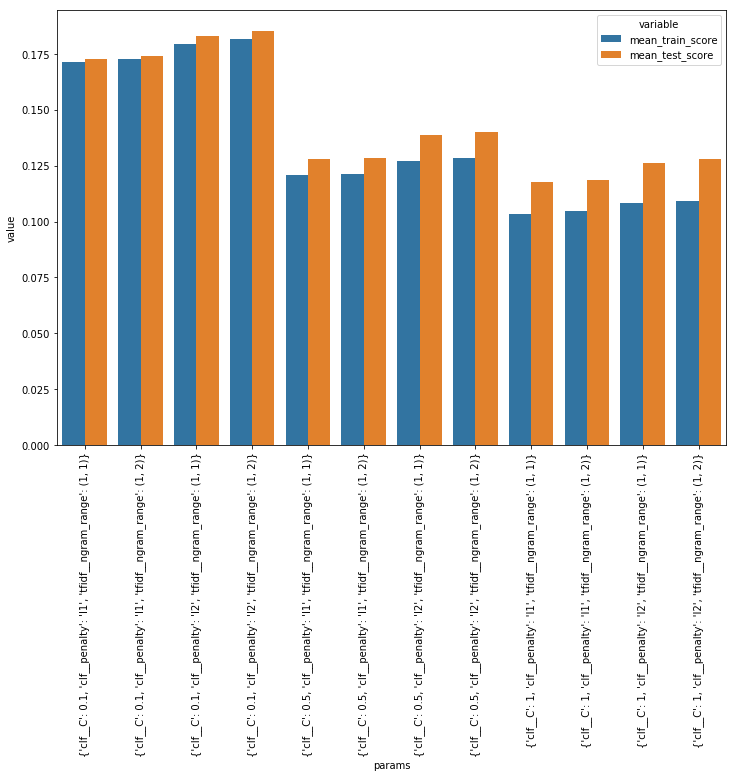

Best log loss : -0.028547474167091195
with parameters : 
{'clf__C': 1, 'clf__penalty': 'l2', 'tfidf__ngram_range': (1, 1)}


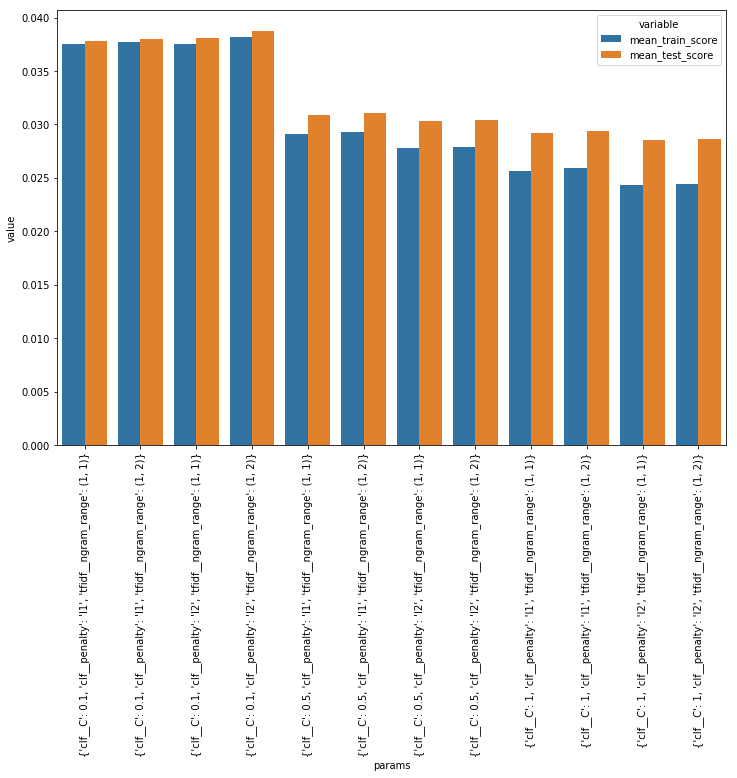

Best log loss : -0.06485506197291632
with parameters : 
{'clf__C': 1, 'clf__penalty': 'l1', 'tfidf__ngram_range': (1, 1)}


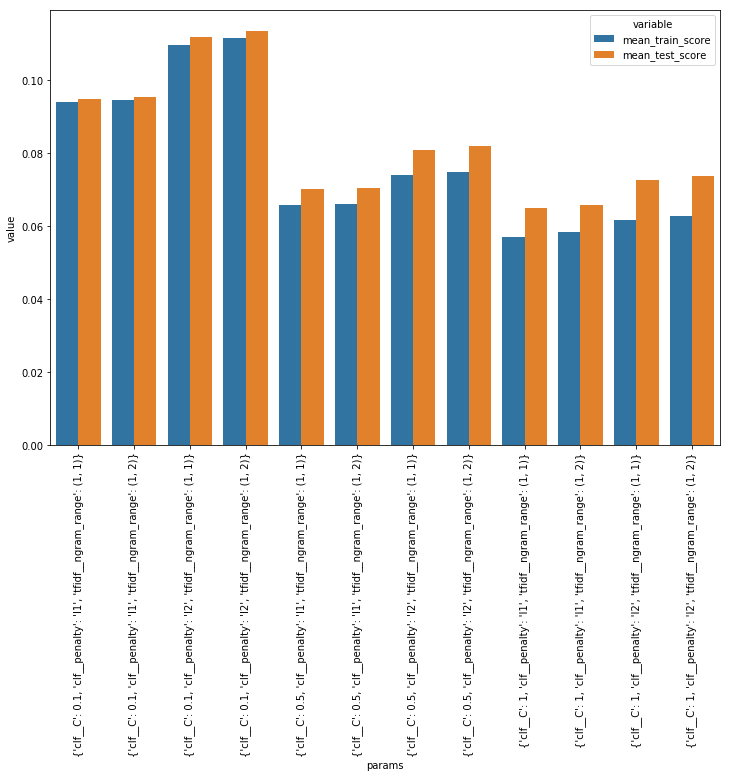

Best log loss : -0.011736508747880785
with parameters : 
{'clf__C': 1, 'clf__penalty': 'l1', 'tfidf__ngram_range': (1, 1)}


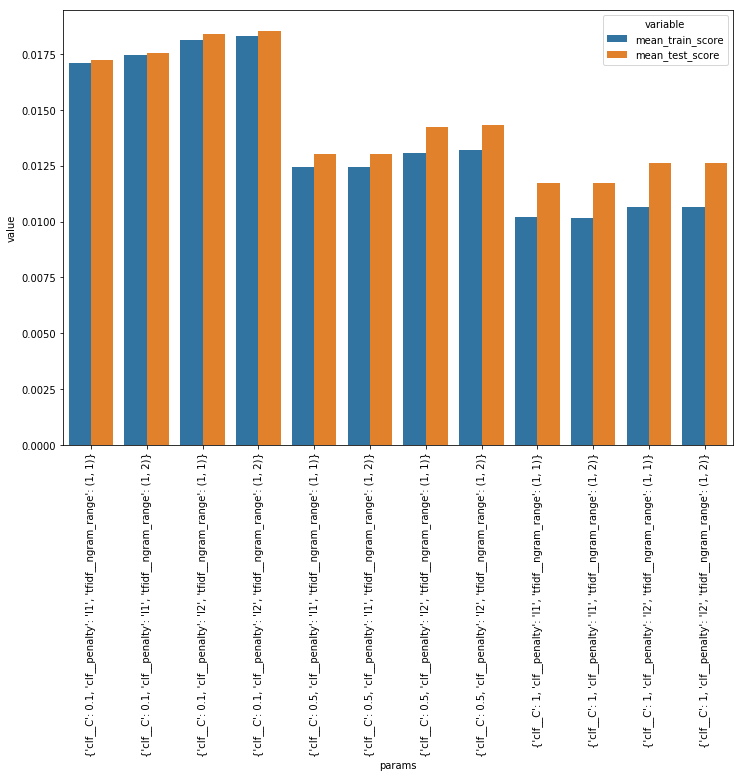

Best log loss : -0.08225070635314212
with parameters : 
{'clf__C': 1, 'clf__penalty': 'l1', 'tfidf__ngram_range': (1, 1)}


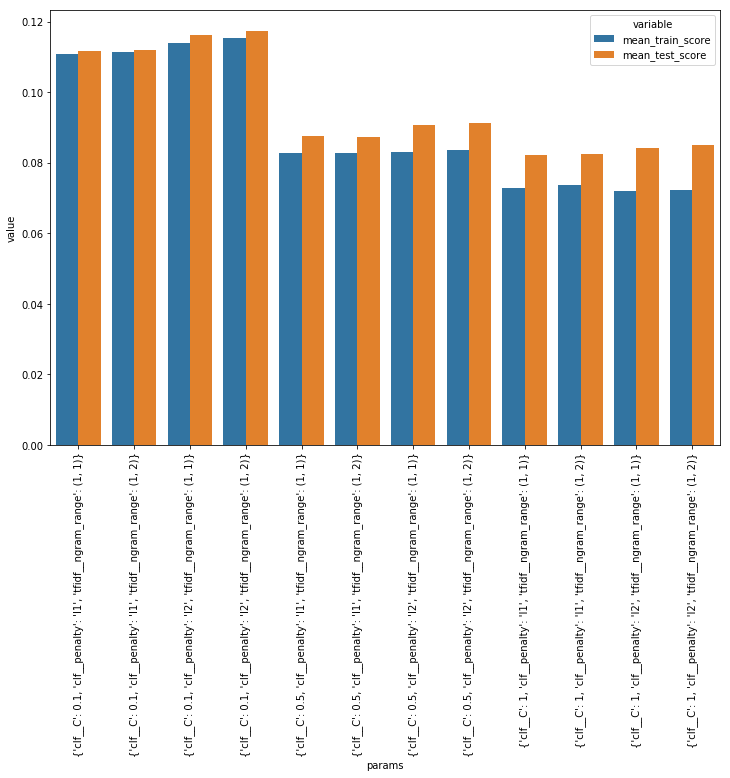

Best log loss : -0.029187440492084587
with parameters : 
{'clf__C': 1, 'clf__penalty': 'l1', 'tfidf__ngram_range': (1, 2)}


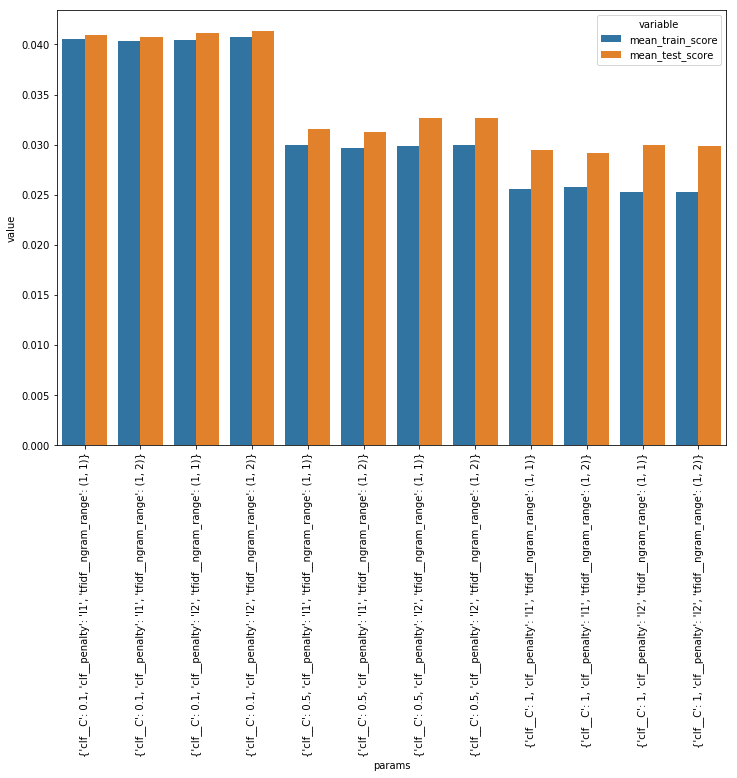

In [7]:
for target in targets:
    result = pd.read_csv("../data/work/result_pipeline_logistic_" + target +
                         ".csv")

    df = result.loc[:, ["mean_train_score", "mean_test_score", "params"]].melt(
        id_vars="params")
    df["value"] = -df["value"]

    print("Best log loss : " + str(result.mean_test_score.max()))
    print("with parameters : ")
    print(result.params.iloc[result.mean_test_score.idxmax()])

    plt.figure(figsize=(12, 8))
    g = sns.barplot(x="params", y="value", hue="variable", data=df)
    for item in g.get_xticklabels():
        item.set_rotation(90)
    plt.show()

In [8]:
best_parameters = []
for target in targets:
    result = pd.read_csv("../data/work/result_pipeline_logistic_" + target + ".csv")
    best_parameters.append(result.iloc[result.mean_test_score.idxmax()].loc[[
        "param_tfidf__ngram_range",
        "param_clf__C",
        "param_clf__penalty",
    ]])
best_parameters = pd.DataFrame(best_parameters, index=targets)

# Predict with best parameters

In [9]:
df_train.comment_text = clean_text(df_train.comment_text)
df_test.comment_text = clean_text(df_test.comment_text)

In [10]:
tfidf = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=30000,
    strip_accents="unicode",
    stop_words="english",
    lowercase=False)
tfidf = tfidf.fit(df_train.comment_text)
tfidf_train = tfidf.transform(df_train.comment_text)
tfidf_test = tfidf.transform(df_test.comment_text)

In [14]:
pred = {}
for target in targets:
    print("Fit and predict on " + target + "...")
    clf = LogisticRegression(
        C=1.0, penalty=best_parameters.loc[target, "param_clf__penalty"])
    clf.fit(tfidf_train, df_train[target])
    pred[target] = clf.predict_proba(tfidf_test)[:, 1]

Fit and predict on toxic...
Fit and predict on severe_toxic...
Fit and predict on obscene...
Fit and predict on threat...
Fit and predict on insult...
Fit and predict on identity_hate...


# Submission

In [15]:
df_submission = pd.read_csv("../data/submissions/sample_submission.csv")
df_submission[targets] = pd.DataFrame(pred)
df_submission.to_csv(
    "../data/submissions/logistic_pipeline_submission.csv", index=False)